<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_HR_gr1/blob/main/Kiparenko%20Nikolai/INSPECTRUM_CLINIC_HR_RECSYS_GR1_AUTO_ML_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSPECTRUM CLINIC HR RECSYS

Рассмотрим вариант создание нейронной сети с помощью инструментов **AvtoML**

В техническом задании прописаны критерии которым должны соответствовать наши модели:

1.  Система должна помогать HR-специалисту вынести решение о том, подходит или не подходит человек на рассматриваемую должность.
2.  В датасете целевым столбцом для предсказания является столбец под названием “Подходит - да/нет”.
3.  Результатом работы обученной нейросети должно служить дополнение датасета столбцом под названием “оценка резюме”, где должно быть представлено процентное распределение вероятностей между классами “подходит” и “не подходит”. Например: "подходит 95% / не подходит 5%".


### Загрузим библиотеки

In [ ]:
# Загрузка датасетов из облака
import gdown

# Функции операционной системы
import os

# Работа с массивами данных
import numpy as np

# Работа с таблицами
import pandas as pd

# автоматически парсит строку и сохранит ее в переменной datetime
import datetime

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Отрисовка графиков
import matplotlib.pyplot as plt
import seaborn as sns # Будем визулизировать данные этой библиотекой

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error



### Инициализация библиотек AvtoML

Инициализация может занять некоторое время

In [ ]:
# H2OAutoML
!pip install h2o
import h2o
from h2o.automl import H2OAutoML
h2o.init()
# Autokeras
!pip install autokeras
import autokeras as ak


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.40.0.4-py2.py3-none-any.whl size=177697886 sha256=88cb5c23f109957cb90e86d2d2655852b7a6f16d866229f91e96a22f8db87014
  Stored in directory: /root/.cache/pip/wheels/43/f2/b0/5bb4d702a0467e82d77c45088db3eef25114c26b0eec8e7f6a
Successfully built h2o
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.19" 2023-04-18; OpenJDK Runtime Environment (build 11.0.19+7-post-Ubuntu-0ubuntu120.04.1); OpenJDK 64-Bit Server VM (build 11.0.19+7-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpueddhav1
  JVM stdout: /tmp/tmpueddhav1/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpueddhav1/h2o_unknownUser_star

H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,2 months
H2O_cluster_name:,H2O_from_python_unknownUser_xphv5e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 58.2 MB/s eta 0:00:00


### Далее загрузим наш датасет и рассмотрим его

In [ ]:
#Грузим файл
path = "https://docs.google.com/spreadsheets/d/1tcfBgGY98cFx1DIvmoRy7goHXNcnaBZ7/export?format=xlsx"
gdown.download(path,'dataS.xlsx', quiet=True)

/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:35: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(


'dataS.xlsx'

Файл содержит в себе множество текстовых полей, постараемся рассмотреть их более внимательно

In [ ]:
#Читаем файл
data = pd.read_excel (r'dataS.xlsx', index_col=0)
data.to_csv('data.csv')
data.head(5)

,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
0,2023-02-23 00:00:00,Женщина,90 000 руб.,Growth Product Manager,"Индонезия, Не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,Опыт работы —5 лет 10 месяцев,PT MYBALI APP GROUP,Менеджер по продукту,Маркетинговые исследования\nИсследование рынка...,NaN,Анализ рынка\nУправление проектами\nProduct Ma...,"Высшее, 2023, Нетоло́гия, 2014, Университет Ро...",23 февраля 2023 в 16:30,да
1,2023-01-11 00:00:00,Женщина,не указана,Growth Product Manager,"Москва, Готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",Опыт работы —11 лет 11 месяцев,Банк Открытие,Product owner трайб сбережения и инвестиции,Участие в команде роста\nВ2В\n\nЗадачи:\n- Раз...,NaN,Самомотивация\nТаймменеджмент\nКреативность\nЧ...,"Высшее, 2022, GeekBrains, 2010, Московский худ...",8 февраля 2023 в 09:15,да
2,2023-02-27 00:00:00,"Мужчина, 33 года, родился 23 августа 1989",150 000 руб.,Growth Product Manager,"Санкт-Петербург, Готов к переезду: Москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —7 лет 2 месяца,DIKIY LLC,,Запуск бренда и производства игристого кваса D...,"Чем бы я ни занимался с 2014 года, когда решил...",Продвижение бренда\nПланирование маркетинговых...,"Высшее, 2013, Санкт-Петербургский государствен...",28 февраля 2023 в 09:41,да
3,2023-01-11 00:00:00,"Мужчина, 32 года, родился 7 декабря 1990",не указана,Growth Product Manager,"Москва, м. Молодежная, Хочу переехать, готов к...","стажировка, частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",Опыт работы —8 лет 10 месяцев,WeInvest,Product Manager (team leader),1. Исследование рынка\n2. Определение целевой ...,"Я проактивный, коммуникабельный, позитивный, д...",Управление проектами\nОрганизаторские навыки\n...,"Магистр, 2014, Московский государственный техн...",24 января 2023 в 12:07,да
4,2023-01-11 00:00:00,"Мужчина, 26 лет, родился 21 февраля 1996",150 000 руб.,Growth Product Manager,"Пермь, Хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —5 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product/Project manager,Переговоры со стейкхолдером\n- Составление ТЗ...,Набрал кучу опыта и хочу с ним найти классную ...,Управление персоналом\nЗаключение договоров\nА...,"Высшее, 2021, Российская академия народного хо...",6 февраля 2023 в 11:18,да


Видим что у нас много "нет" и всего 11 "да" на весь датасет

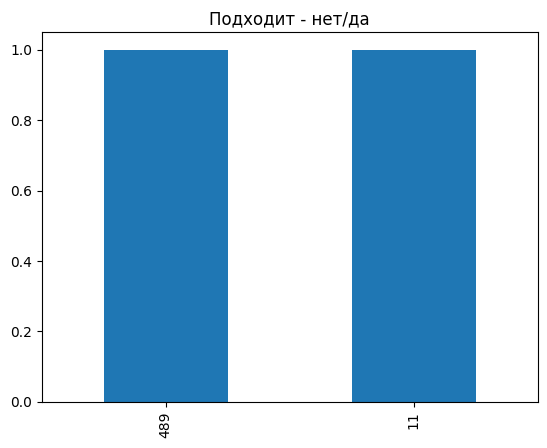

In [ ]:
#Смотрим на распределение признаков Подходит - да/нет
countsSuitable = data['Подходит - да/нет'].value_counts()
countsSuitable.value_counts().plot(kind='bar', label='Suitable')
plt.title('Подходит - нет/да')
plt.show()


Больше всего "да" у Growth Product Manager (5) и HR-специалист(4)

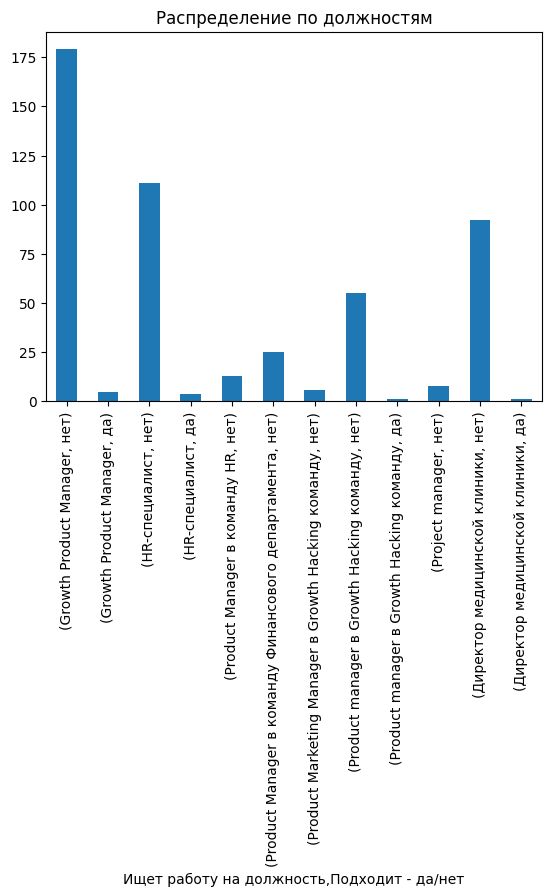

Ищет работу на должность                            Подходит - да/нет
Growth Product Manager                              нет                  179
                                                    да                     5
HR-специалист                                       нет                  111
                                                    да                     4
Product Manager в команду HR                        нет                   13
Product Manager в команду Финансового департамента  нет                   25
Product Marketing Manager в Growth Hacking команду  нет                    6
Product manager в Growth Hacking команду            нет                   55
                                                    да                     1
Project manager                                     нет                    8
Директор медицинской клиники                        нет                   92
                                                    да                     1
Name: 

In [ ]:
#Смотрим на распределение признаков относительно должностей
countsJob = data.groupby('Ищет работу на должность')['Подходит - да/нет'].value_counts()
countsJob.plot(kind='bar', label='Suitable')
plt.title('Распределение по должностям')
plt.show()

countsJob

Такой не сбалансированный датасет обычно не подходит для обучения но мы постараемся немного его нормализовать

### Обучение модели с помощью AutoML H2O

AutoML H2O можно использовать для автоматизации рабочего процесса машинного обучения, который включает в себя автоматическое обучение и настройку многих моделей в течение заданного пользователем срока.
https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html#

In [ ]:
#Читаем файл в Дата фрейм
df = h2o.import_file("data.csv",header =1)
#Удаляем поле с индексом стоки
df = df[:,1:]


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


splitFrame позволяет разделить выборки, задодим разделения 0,65/0,25 H2O создаст разделение тест/обучение с ожидаемым значением 0,65/0,25, а не точно 0,65/0,25.

In [ ]:
train, test, valid = df.split_frame ( ratios = [ .65 , .25 ])

y = "Подходит - да/нет"

x_train= train.columns
#Удаляем поле "Подходит - да/нет" из обучаемого датасета
x_test = train.columns
x_test = x_test.remove(y)
x_train.remove(y)
#Удаляем ошибочные поля
x_train.remove("Дата отклика")
x_train.remove("Обновление резюме")
#x_train.remove("Выполняемые задачи на прошлых местах работ")

Запускаем поиск наиболее лучшей модели

In [ ]:
aml_1 = H2OAutoML(max_models = 10, seed = 1)
hist = aml_1.train(x = x_train, y = y, training_frame = train)

AutoML progress: |
16:34:14.58: _train param, Dropping bad and constant columns: [Выполняемые задачи на прошлых местах работ]
16:34:14.126: XGBoost_1_AutoML_3_20230628_163414 [XGBoost def_2] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for XGBoost model: XGBoost_1_AutoML_3_20230628_163414_cv_1.  Details: ERRR on field: _response_column: Response contains missing values (NAs) - not supported by XGBoost.

16:34:14.135: _train param, Dropping bad and constant columns: [Выполняемые задачи на прошлых местах работ]

██████████
16:35:00.488: _train param, Dropping bad and constant columns: [Выполняемые задачи на прошлых местах работ]


16:35:06.112: _train param, Dropping bad and constant columns: [Выполняемые задачи на прошлых местах работ]
16:35:06.135: XGBoost_2_AutoML_3_20230628_163414 [XGBoost def_1] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for XGBoost model: XGBoost_2_AutoML_3_20230628_163414_cv_1.  De

### Анализ обучения

Получаем лучшую модель, используя метрику


**mean_per_class_error** - это мера средней ошибки классификации для каждого класса в наборе данных. Она вычисляется как среднее значение ошибок для каждого класса, деленное на количество классов. Чем меньше значение MCCE, тем лучше модель.

**Log-loss** - это функция потерь, которая используется в задачах регрессии и классификации. Она также используется для оценки качества модели. Log-loss вычисляется путем суммирования логарифмов значений ошибок прогнозирования и деления этой суммы на количество наблюдений. Чем меньше значение log-loss, тем лучше модель.

**RMSE** - это метрика для оценки среднеквадратической ошибки между прогнозами модели и фактическими значениями. Чем меньше RMSE, тем точнее модель.

**MSE** - это еще одна метрика, используемая для оценки точности модели. Она рассчитывается как среднее квадратическое отклонение прогнозируемых значений от фактических значений. Чем меньше MSE, тем ближе модель к действительности.

In [ ]:
# Получаем лучшую модель, используя метрику
best_model_1 = aml_1.leader
# Посмотрим метрику
lb = aml_1.leaderboard
lb.head()

model_id,mean_per_class_error,logloss,rmse,mse
DRF_1_AutoML_3_20230628_163414,0.555556,0.701973,0.217369,0.0472494
StackedEnsemble_BestOfFamily_1_AutoML_3_20230628_163414,0.555556,0.232517,0.214151,0.0458609
XRT_1_AutoML_3_20230628_163414,0.555556,1.0121,0.215648,0.046504
GLM_1_AutoML_3_20230628_163414,0.555556,0.232517,0.214151,0.0458609
StackedEnsemble_AllModels_1_AutoML_3_20230628_163414,0.555556,0.232517,0.214151,0.0458609
DeepLearning_1_AutoML_3_20230628_163414,0.555939,0.259736,0.23249,0.0540516
GBM_grid_1_AutoML_3_20230628_163414_model_1,0.556322,0.363608,0.22937,0.0526104
GBM_2_AutoML_3_20230628_163414,0.556322,0.392749,0.236499,0.0559317
GBM_3_AutoML_3_20230628_163414,0.556705,0.401823,0.239362,0.0572944
GBM_4_AutoML_3_20230628_163414,0.557088,0.407147,0.242046,0.0585862


In [ ]:
# Получим список параметров модели
best_model_1.params.keys()

dict_keys(['model_id', 'training_frame', 'validation_frame', 'nfolds', 'keep_cross_validation_models', 'keep_cross_validation_predictions', 'keep_cross_validation_fold_assignment', 'score_each_iteration', 'score_tree_interval', 'fold_assignment', 'fold_column', 'response_column', 'ignored_columns', 'ignore_const_cols', 'offset_column', 'weights_column', 'balance_classes', 'class_sampling_factors', 'max_after_balance_size', 'max_confusion_matrix_size', 'ntrees', 'max_depth', 'min_rows', 'nbins', 'nbins_top_level', 'nbins_cats', 'r2_stopping', 'stopping_rounds', 'stopping_metric', 'stopping_tolerance', 'max_runtime_secs', 'seed', 'build_tree_one_node', 'mtries', 'sample_rate', 'sample_rate_per_class', 'binomial_double_trees', 'checkpoint', 'col_sample_rate_change_per_level', 'col_sample_rate_per_tree', 'min_split_improvement', 'histogram_type', 'categorical_encoding', 'calibrate_model', 'calibration_frame', 'calibration_method', 'distribution', 'custom_metric_func', 'export_checkpoints_d

Посмотрим график обучения лучшей модели

**График кривой обучения**
График кривой обучения показывает функцию потерь / метрику, зависящую от количества итераций или деревьев для древовидных алгоритмов. Этот график может быть полезен для определения того, подходит ли модель чрезмерно.

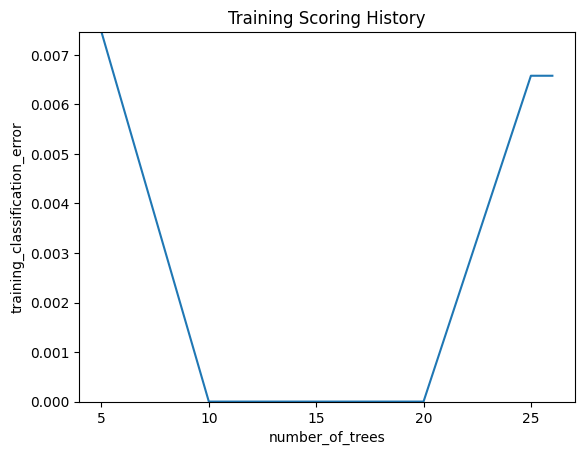

In [ ]:
best_model_1.plot()

Важность переменных представляет собой статистическую значимость каждой переменной в данных с точки зрения ее влияния на модель. Переменные перечислены в порядке от наибольшей до наименьшей важности. Процентные значения представляют собой процент важности всех переменных, масштабированный до 100%. Метод вычисления важности каждой переменной зависит от алгоритма.

**Переменная важность**
График важности переменных показывает относительную важность наиболее важных переменных в модели.

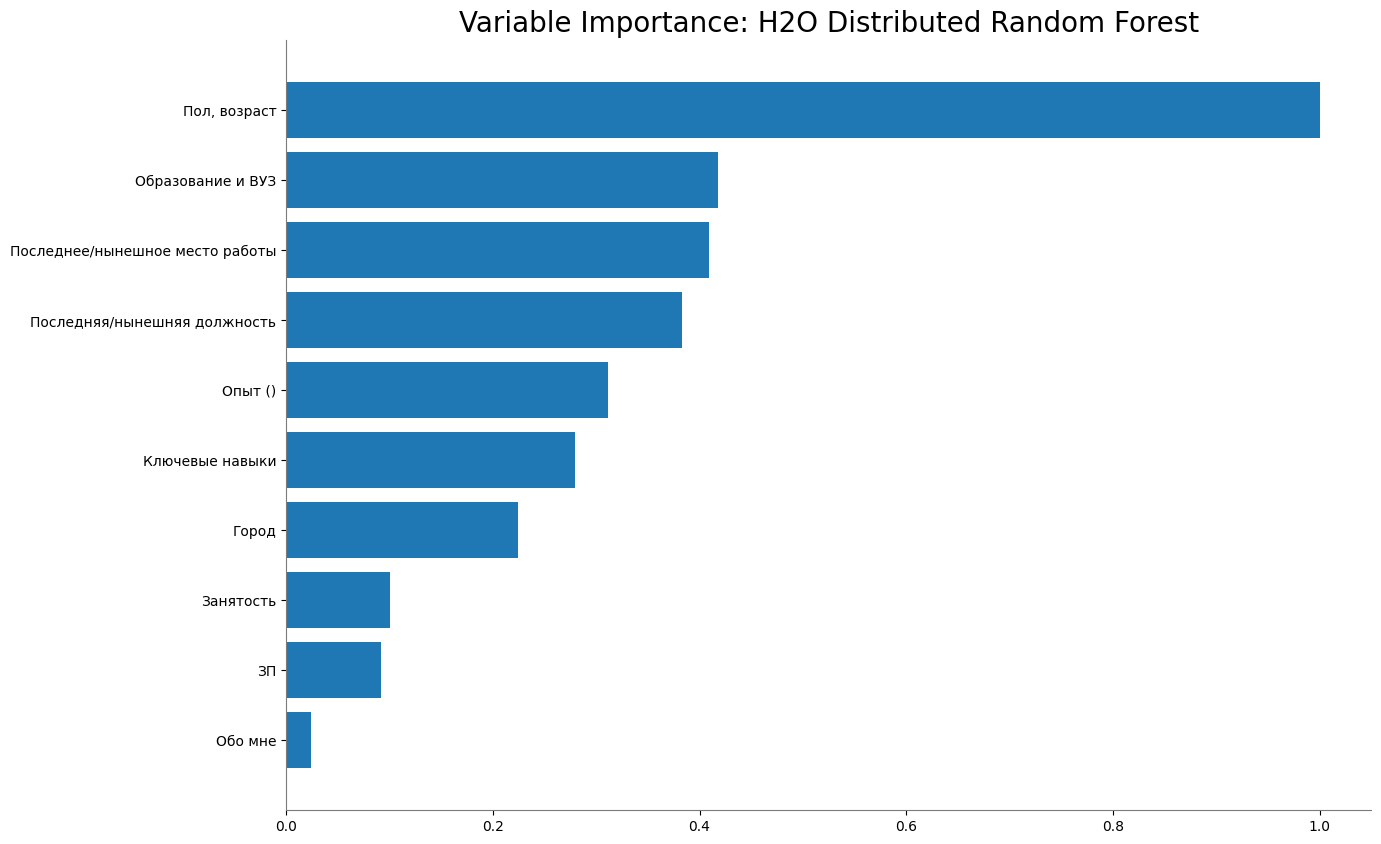

<Figure size 640x480 with 0 Axes>

In [ ]:
best_model_1.varimp_plot()

**Тепловая карта важности переменной**
Тепловая карта переменной важности показывает переменную важность для нескольких моделей. Некоторые модели в H2O возвращают важность переменной для версий категориальных столбцов, закодированных с помощью одного горячего (двоичного индикатора) (например, Deep Learning, XGBoost). Чтобы значение переменной важности категориальных столбцов можно было сравнить во всех типах моделей, мы вычисляем суммирование важности переменной для всех функций с горячим кодированием и возвращаем значение одной переменной для исходной категориальной функции. По умолчанию модели и переменные упорядочены по их сходству.

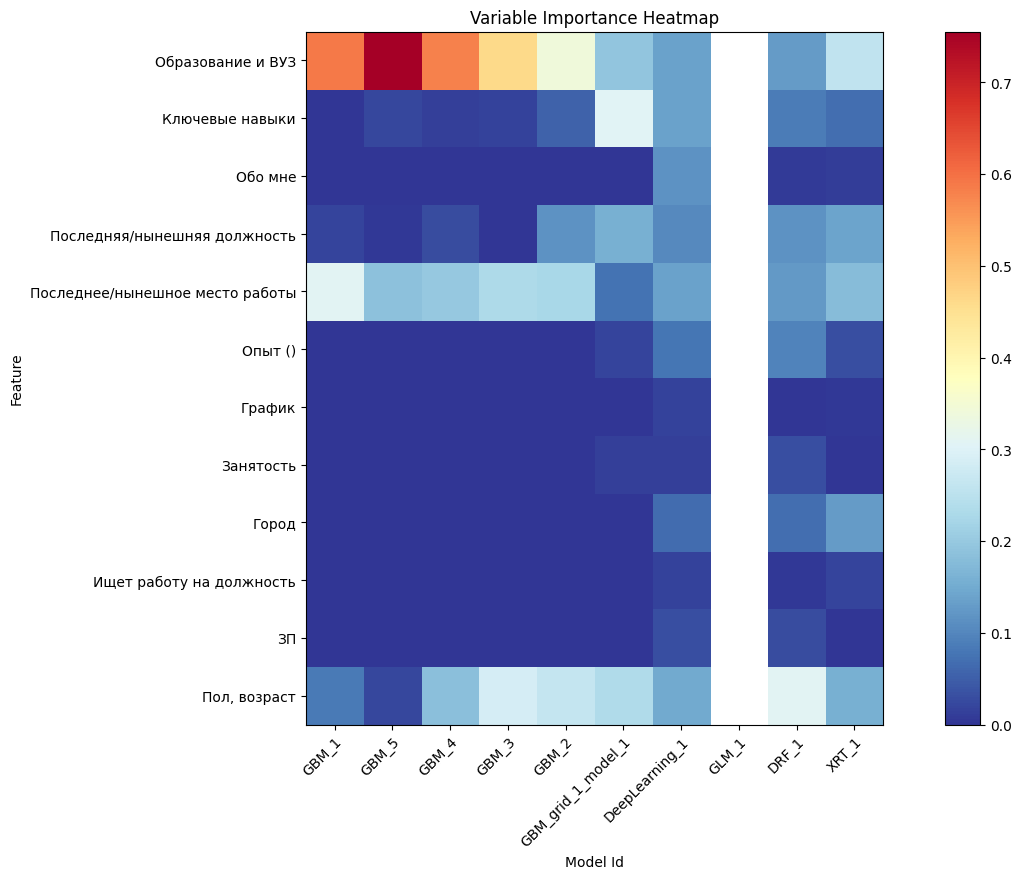

In [ ]:
va_plot = aml_1.varimp_heatmap()

### Производительность модели

H2O-3 предоставляет множество показателей, которые можно использовать для оценки контролируемых и неконтролируемых моделей. Показатели в этом разделе охватывают только модели контролируемого обучения, которые различаются в зависимости от типа модели (классификация или регрессия).

In [ ]:
perf = best_model_1.model_performance(test)
print(perf)


ModelMetricsMultinomial: drf
** Reported on test data. **

MSE: 0.019761986080683757
RMSE: 0.1405773313186865
LogLoss: 0.5041787557963199
Mean Per-Class Error: 0.3333333333333333
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
госорганом.    госорганом.     да    к способам доставки – почту России    контент-планирование    нет    оптимизация налогообложения внешнеэкономической деятельности    организация диспетчеризации и обработки заявок с чат ботом на первой линии);    строительно-монтажные услуги    Error      Rate
-------------  --------------  ----  ------------------------------------  ----------------------  -----  ---------

### Прогноз модели

С помощью H2O-3 вы можете генерировать прогнозы для модели на основе образцов в тестовом наборе

In [ ]:
preds = best_model_1.predict(test)
print(preds)


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
predict      госорганом.    госорганом.            да    к способам доставки – почту России    контент-планирование       нет    оптимизация налогообложения внешнеэкономической деятельности    организация диспетчеризации и обработки заявок с чат ботом на первой линии);    строительно-монтажные услуги
нет                    0               0  0.000652427                                     0                       0  0.999348                                                               0                                                                               0                               0
нет                    0               0  0.000652427                                     0                       0  0.999348                                                               0                                                                               0                               0